In [8]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_split import SplitMnistGenerator, SplitMnistRandomGenerator, SplitMnistBackgroundGenerator
from run_not import NotMnistGenerator
from alg.cla_models_multihead import Vanilla_NN
from alg.IBP_BNN_multihead import IBP_BNN
from alg.HIBP_BNN_multihead import HIBP_BNN
from alg.utils import get_scores, concatenate_results
from alg.vcl import run_vcl, run_vcl_ibp
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

In [21]:
difficult = False
single_head = True
num_layers = 2
runs = 1
log_dir = 'logs'
dataset = 'normal'
use_local_reparam=False
implicit_beta = True
hibp=True
run_baselines=True
h_list=[5]
cl3=False
tag='test_stepbeta1_sh'

seeds = list(range(1, 1 + runs))
num_tasks = 5

vcl_ibp_accs = np.zeros((len(seeds), num_tasks, num_tasks))
baseline_accs = {h: np.zeros((len(seeds), num_tasks, num_tasks)) for h in h_list}
all_ibp_uncerts = np.zeros((len(seeds), num_tasks, num_tasks))
baseline_uncerts = {h: np.zeros((len(seeds), num_tasks, num_tasks)) for h in h_list}
all_Zs = []

# We don't need a validation set
val = False

def get_datagen():
    if dataset == 'normal':
        data_gen = SplitMnistGenerator(val=val, difficult=difficult, cl3=cl3)
    elif args.dataset == 'random':
        data_gen = SplitMnistRandomGenerator(val=val, cl3=cl3)
    elif args.dataset == 'background':
        data_gen = SplitMnistBackgroundGenerator(val=val, cl3=cl3)
    else:
        raise ValueError('Pick dataset in {normal, random, background}')
    return data_gen

# IBP params
alpha0 = 5.0
beta0 = 1.0
lambda_1 = 0.7
lambda_2 = 0.7
alpha = 4.0
# Gaussian params
prior_mean = 0.0
prior_var = 0.7
beta_1 = [1.0] + [100.0] * (num_tasks-1)

for i in range(len(seeds)):
    s = seeds[i]
    hidden_size = [100] * num_layers
    batch_size = 512
    no_epochs = 600
    ibp_samples = 10
    no_pred_samples = 100

    tf.set_random_seed(s)
    np.random.seed(1)

    coreset_size = 0
    data_gen = get_datagen()
    name = "split_{0}_{1}".format(dataset, tag)
    # Z matrix for each task is output
    # This is overwritten for each run
    ibp_acc, Zs, uncerts = run_vcl_ibp(hidden_size=hidden_size, alphas=[alpha]*len(hidden_size),
                                       no_epochs= [int(no_epochs*1.2)] + [no_epochs]*(num_tasks-1), data_gen=data_gen,
                                       name=name, val=val, batch_size=batch_size, single_head=single_head,
                                       prior_mean=prior_mean, prior_var=prior_var, alpha0=alpha0,
                                       beta0=beta0, lambda_1=lambda_1, lambda_2=lambda_2,
                                       learning_rate=[0.001]*num_tasks,
                                       no_pred_samples=no_pred_samples, ibp_samples=ibp_samples, log_dir=log_dir,
                                       use_local_reparam=use_local_reparam,
                                       implicit_beta=implicit_beta, hibp=hibp, beta_1=beta_1)

    all_Zs.append(Zs)
    vcl_ibp_accs[i, :, :] = ibp_acc
    all_ibp_uncerts[i, :, :] = uncerts

Epoch: 0001 cost= 0.184454437
Epoch: 0006 cost= 0.001547942
Epoch: 0011 cost= 0.000527232
Epoch: 0016 cost= 0.000164122
Epoch: 0021 cost= 0.000079562
Epoch: 0026 cost= 0.000039082
Epoch: 0031 cost= 0.000021302
Epoch: 0036 cost= 0.000012487
Epoch: 0041 cost= 0.000008293
Epoch: 0046 cost= 0.000005889
Epoch: 0051 cost= 0.000004352
Epoch: 0056 cost= 0.000003321
Epoch: 0061 cost= 0.000002621
Epoch: 0066 cost= 0.000002128
Epoch: 0071 cost= 0.000001753
Epoch: 0076 cost= 0.000001455
Epoch: 0081 cost= 0.000001257
Epoch: 0086 cost= 0.000001039
Epoch: 0091 cost= 0.000000898
Epoch: 0096 cost= 0.000000797
Z: (1, ?, 100)
Z: (1, ?, 100)
New model, training
Epoch: 0001 train cost= 16.309425888
Epoch: 0006 train cost= 15.919775543
Epoch: 0011 train cost= 14.845346947
Epoch: 0016 train cost= 15.044516983
Epoch: 0021 train cost= 14.049472580
Epoch: 0026 train cost= 14.232326584
Epoch: 0031 train cost= 13.284121628
Epoch: 0036 train cost= 13.451957970
Epoch: 0041 train cost= 12.550797729
Epoch: 0046 train

Epoch: 0321 train cost= 1.253673156
Epoch: 0326 train cost= 1.229782571
Epoch: 0331 train cost= 1.196688637
Epoch: 0336 train cost= 1.186479966
Epoch: 0341 train cost= 1.181009923
Epoch: 0346 train cost= 1.156238938
Epoch: 0351 train cost= 1.156991675
Epoch: 0356 train cost= 1.127176811
Epoch: 0361 train cost= 1.110780636
Epoch: 0366 train cost= 1.095907008
Epoch: 0371 train cost= 1.089754631
Epoch: 0376 train cost= 1.023809445
Epoch: 0381 train cost= 1.056722308
Epoch: 0386 train cost= 1.001127414
Epoch: 0391 train cost= 1.016020837
Epoch: 0396 train cost= 0.994087632
Epoch: 0401 train cost= 1.013127541
Epoch: 0406 train cost= 1.026556549
Epoch: 0411 train cost= 1.013334843
Epoch: 0416 train cost= 0.978225249
Epoch: 0421 train cost= 0.985893734
Epoch: 0426 train cost= 0.976690809
Epoch: 0431 train cost= 0.982896959
Epoch: 0436 train cost= 0.976998421
Epoch: 0441 train cost= 0.962227732
Epoch: 0446 train cost= 0.948820747
Epoch: 0451 train cost= 0.944424378
Epoch: 0456 train cost= 0.95

Epoch: 0246 train cost= 1.205488453
Epoch: 0251 train cost= 1.096838966
Epoch: 0256 train cost= 1.117922614
Epoch: 0261 train cost= 1.050906807
Epoch: 0266 train cost= 1.063058625
Epoch: 0271 train cost= 0.990732191
Epoch: 0276 train cost= 1.001395273
Epoch: 0281 train cost= 0.985320474
Epoch: 0286 train cost= 0.951110703
Epoch: 0291 train cost= 0.928380728
Epoch: 0296 train cost= 0.909792446
Epoch: 0301 train cost= 0.879396814
Epoch: 0306 train cost= 0.855853486
Epoch: 0311 train cost= 0.843078467
Epoch: 0316 train cost= 0.814577835
Epoch: 0321 train cost= 0.791964546
Epoch: 0326 train cost= 0.779757035
Epoch: 0331 train cost= 0.754876152
Epoch: 0336 train cost= 0.742976179
Epoch: 0341 train cost= 0.719636366
Epoch: 0346 train cost= 0.707912957
Epoch: 0351 train cost= 0.691628888
Epoch: 0356 train cost= 0.675473188
Epoch: 0361 train cost= 0.655374298
Epoch: 0366 train cost= 0.655056911
Epoch: 0371 train cost= 0.624101629
Epoch: 0376 train cost= 0.583405092
Epoch: 0381 train cost= 0.62

In [19]:
ibp_acc

array([[0.99952719,        nan,        nan,        nan,        nan],
       [0.99810875, 0.84867777,        nan,        nan,        nan],
       [0.93286052, 0.65866797, 0.85325507,        nan,        nan],
       [0.89598109, 0.7115573 , 0.81270011, 0.96424975,        nan],
       [0.85106383, 0.7575906 , 0.8153682 , 0.91792548, 0.79374685]])

In [20]:
np.nanmean(ibp_acc) # step [1, 100, 110, 120, 130]

0.8540853634741369

In [16]:
ibp_acc

array([[0.99905437,        nan,        nan,        nan,        nan],
       [0.99905437, 0.81390793,        nan,        nan,        nan],
       [0.99574468, 0.6748286 , 0.77481323,        nan,        nan],
       [0.97021277, 0.58765916, 0.7529349 , 0.76233635,        nan],
       [0.96453901, 0.56953967, 0.71558164, 0.75730111, 0.66011094]])

In [17]:
np.nanmean(ibp_acc) # [1, 100, 200, 300, 400]

0.7998412493046688

In [10]:
ibp_acc

array([[0.99952719,        nan,        nan,        nan,        nan],
       [0.99905437, 0.85308521,        nan,        nan,        nan],
       [0.99858156, 0.84720862, 0.84738527,        nan,        nan],
       [0.98770686, 0.89471107, 0.79935966, 0.96374622,        nan],
       [0.8893617 , 0.76003918, 0.74012807, 0.82326284, 0.90065557]])

In [11]:
np.nanmean(ibp_acc) # [1, 100, 100, 100, 100]

0.8869208925110533

In [5]:
vcl_ibp_accs

array([[[0.99952719,        nan,        nan,        nan,        nan],
        [0.97966903, 0.97747307,        nan,        nan,        nan],
        [0.5858156 , 0.86385896, 0.98559232,        nan,        nan],
        [0.64349882, 0.90744368, 0.76840982, 0.99093656,        nan],
        [0.356974  , 0.68854065, 0.24919957, 0.97230614, 0.96923853]]])

In [12]:
np.nanmean(vcl_ibp_accs)

0.8869208925110533

In [ ]:
ibp_acc  

NameError: name '_ibp_acc' is not defined

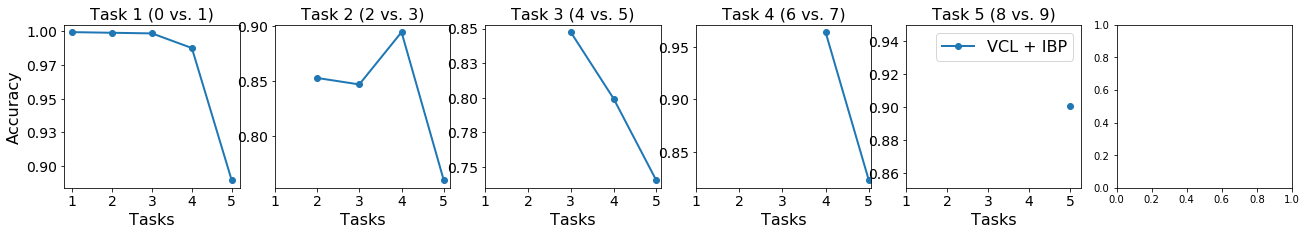

In [13]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h5[0][:, i], label='VCL h5', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h10[0][:, i], label='VCL h10', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h50[0][:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(ibp_acc[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
#plt.savefig(\"plots/perm_mnist_all.pdf\", bbox_inches='tight')
fig.show()

NameError: name '_ibp_acc' is not defined

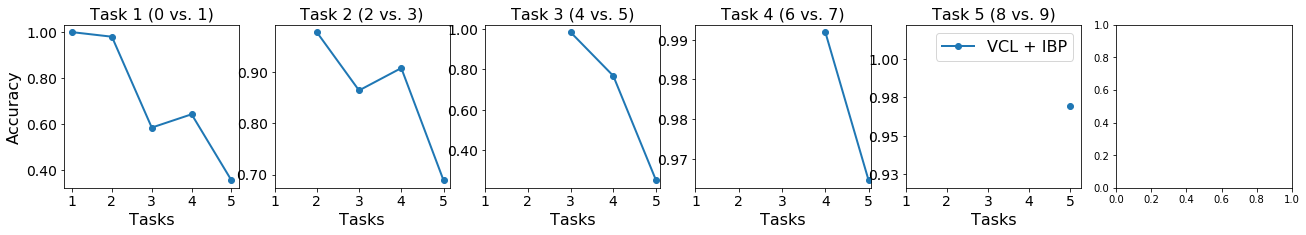

In [7]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h5[0][:, i], label='VCL h5', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h10[0][:, i], label='VCL h10', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h50[0][:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(ibp_acc[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
#plt.savefig(\"plots/perm_mnist_all.pdf\", bbox_inches='tight')
fig.show()

In [12]:
vcl_ibp_accs

array([[[0.99952719,        nan,        nan,        nan,        nan],
        [0.73758865, 0.98628795,        nan,        nan,        nan],
        [0.23073286, 0.8805093 , 0.99839915,        nan,        nan],
        [0.30732861, 0.90940255, 0.94076841, 0.99748238,        nan],
        [0.30827423, 0.89177277, 0.9493063 , 0.95367573, 0.98436712]]])

In [13]:
np.nanmean(vcl_ibp_accs)

0.8050282128361428

In [14]:
_ibp_acc = np.nanmean(ibp_acc, 1) # each row is averaged!
#_vcl_result_h10 = np.nanmean(vcl_result_h10[0], 1)
#_vcl_result_h5 = np.nanmean(vcl_result_h5[0], 1)
#_vcl_result_h50 = np.nanmean(vcl_result_h50[0], 1)

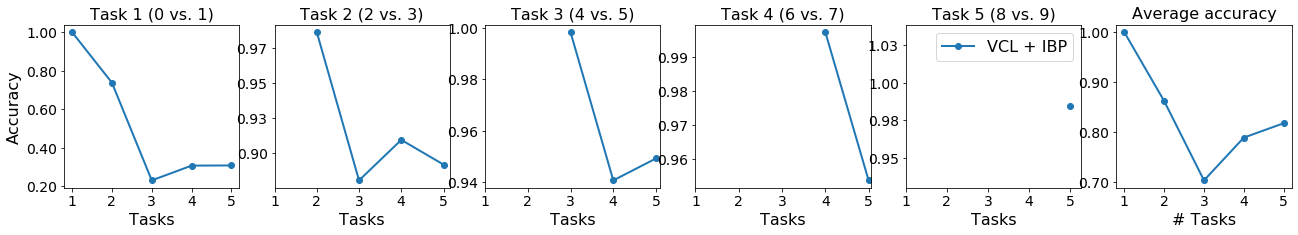

In [15]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h5[0][:, i], label='VCL h5', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h10[0][:, i], label='VCL h10', marker='o', linewidth=lw)
    #ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, vcl_result_h50[0][:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(ibp_acc[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o', linewidth=lw)
#ax[5].plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
#plt.savefig(\"plots/perm_mnist_all.pdf\", bbox_inches='tight')
fig.show()

In [16]:
print(np.nanmean(ibp_acc))
print(np.nanmean(vcl_result_h10[0]))
print(np.nanmean(vcl_result_h5[0]))
print(np.nanmean(vcl_result_h50[0]))

0.8050282128361428


NameError: name 'vcl_result_h10' is not defined

In [56]:
with open('results/split_mnist_sh.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)

# Not MNIST

In [57]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = NotMnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
#x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    #x_valsets.append(x_val)
    #y_valsets.append(y_val)
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=learning_rate, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_not')

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.147950740
Epoch: 0006 cost= 0.052100334
Epoch: 0011 cost= 0.027261425
Epoch: 0016 cost= 0.016392342
Epoch: 0021 cost= 0.012724730
Epoch: 0026 cost= 0.011206084
Epoch: 0031 cost= 0.010892851
Epoch: 0036 cost= 0.008530463
Epoch: 0041 cost= 0.008514597
Epoch: 0046 cost= 0.007187106
Epoch: 0051 cost= 0.008457751
Epoch: 0056 cost= 0.008551123
Epoch: 0061 cost= 0.007755257
Epoch: 0066 cost= 0.006361756
Epoch: 0071 cost= 0.004637599
Epoch: 0076 cost= 0.007298294
Epoch: 0081 cost= 0.007662674
Epoch: 0086 cost= 0.007053139
Epoch: 0091 cost= 0.007399848
Epoch: 0096 cost= 0.005222385
Epoch: 0101 cost= 0.006111367
Epoch: 0106 cost= 0.004928066
Epoch: 0111 cost= 0.007485502
Epoch: 0116 cost= 0.003434861
Epoch: 0121 cost= 0.006662809
Epoch: 0126 cost= 0.004171039
Epoch: 0131 cost= 0.004220554
Epoch: 0136 cost= 0.004703483
Epoch: 0141 cost= 0.004993734
Epoch: 0146 cost= 0.007615835
Epoch: 0151 cost= 0.005706291
Epoch: 0156 cost= 0.004756697
Epoch: 0161 cost= 0.005239427
Epoch: 016

Epoch: 0196 train cost= 0.185035757
Epoch: 0201 train cost= 0.185209169
Epoch: 0206 train cost= 0.184903419
Epoch: 0211 train cost= 0.184326771
Epoch: 0216 train cost= 0.183576571
Epoch: 0221 train cost= 0.183911950
Epoch: 0226 train cost= 0.183465574
Epoch: 0231 train cost= 0.184351507
Epoch: 0236 train cost= 0.183443937
Epoch: 0241 train cost= 0.182108271
Epoch: 0246 train cost= 0.183971417
Epoch: 0251 train cost= 0.182951321
Epoch: 0256 train cost= 0.183142166
Epoch: 0261 train cost= 0.182533150
Epoch: 0266 train cost= 0.182967111
Epoch: 0271 train cost= 0.181919298
Epoch: 0276 train cost= 0.182287182
Epoch: 0281 train cost= 0.182250887
Epoch: 0286 train cost= 0.181154738
Epoch: 0291 train cost= 0.180891431
Epoch: 0296 train cost= 0.181709207
Epoch: 0301 train cost= 0.182257229
Epoch: 0306 train cost= 0.181270699
Epoch: 0311 train cost= 0.181120714
Epoch: 0316 train cost= 0.180711877
Epoch: 0321 train cost= 0.180880935
Epoch: 0326 train cost= 0.180626418
Epoch: 0331 train cost= 0.18

Epoch: 0306 train cost= 0.207066099
Epoch: 0311 train cost= 0.207180830
Epoch: 0316 train cost= 0.206017970
Epoch: 0321 train cost= 0.207037361
Epoch: 0326 train cost= 0.207184487
Epoch: 0331 train cost= 0.205552724
Epoch: 0336 train cost= 0.206246939
Epoch: 0341 train cost= 0.206282117
Epoch: 0346 train cost= 0.206240387
Epoch: 0351 train cost= 0.206702051
Epoch: 0356 train cost= 0.205680377
Epoch: 0361 train cost= 0.206088974
Epoch: 0366 train cost= 0.205819563
Epoch: 0371 train cost= 0.206562018
Epoch: 0376 train cost= 0.206553730
Epoch: 0381 train cost= 0.206043332
Epoch: 0386 train cost= 0.206292624
Epoch: 0391 train cost= 0.205590546
Epoch: 0396 train cost= 0.206216920
Epoch: 0401 train cost= 0.205930121
Epoch: 0406 train cost= 0.205879759
Epoch: 0411 train cost= 0.205626552
Epoch: 0416 train cost= 0.204384129
Epoch: 0421 train cost= 0.205408882
Epoch: 0426 train cost= 0.205779543
Epoch: 0431 train cost= 0.205868918
Epoch: 0436 train cost= 0.205693875
Epoch: 0441 train cost= 0.20

array([[0.9845,    nan,    nan,    nan,    nan],
       [0.9765, 0.9825,    nan,    nan,    nan],
       [0.9635, 0.964 , 0.977 ,    nan,    nan],
       [0.952 , 0.947 , 0.9615, 0.9775,    nan],
       [0.739 , 0.9225, 0.912 , 0.971 , 0.9565]])

In [58]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [10]
data_gen = NotMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result)

Epoch: 0001 cost= 0.177553392
Epoch: 0006 cost= 0.093638897
Epoch: 0011 cost= 0.078150333
Epoch: 0016 cost= 0.066872108
Epoch: 0021 cost= 0.059287362
Epoch: 0026 cost= 0.053082626
Epoch: 0031 cost= 0.048444979
Epoch: 0036 cost= 0.042576688
Epoch: 0041 cost= 0.038615589
Epoch: 0046 cost= 0.036978674
Epoch: 0051 cost= 0.033063979
Epoch: 0056 cost= 0.030136950
Epoch: 0061 cost= 0.028382677
Epoch: 0066 cost= 0.026152857
Epoch: 0071 cost= 0.023977344
Epoch: 0076 cost= 0.020861923
Epoch: 0081 cost= 0.020920846
Epoch: 0086 cost= 0.019431033
Epoch: 0091 cost= 0.020166555
Epoch: 0096 cost= 0.019042254
Epoch: 0101 cost= 0.016541136
Epoch: 0106 cost= 0.015748448
Epoch: 0111 cost= 0.013949033
Epoch: 0116 cost= 0.016568195
Epoch: 0121 cost= 0.013016307
Epoch: 0126 cost= 0.014191355
Epoch: 0131 cost= 0.013861872
Epoch: 0136 cost= 0.011462396
Epoch: 0141 cost= 0.012609415
Epoch: 0146 cost= 0.010703935
Epoch: 0151 cost= 0.010916434
Epoch: 0156 cost= 0.012521804
Epoch: 0161 cost= 0.010655577
Epoch: 016

Epoch: 0361 cost= 0.116001311
Epoch: 0366 cost= 0.115048699
Epoch: 0371 cost= 0.115167842
Epoch: 0376 cost= 0.115874771
Epoch: 0381 cost= 0.115839725
Epoch: 0386 cost= 0.115560939
Epoch: 0391 cost= 0.115668914
Epoch: 0396 cost= 0.115902931
Epoch: 0401 cost= 0.114908494
Epoch: 0406 cost= 0.115570498
Epoch: 0411 cost= 0.115311111
Epoch: 0416 cost= 0.115634115
Epoch: 0421 cost= 0.115692576
Epoch: 0426 cost= 0.114805793
Epoch: 0431 cost= 0.115090266
Epoch: 0436 cost= 0.115770041
Epoch: 0441 cost= 0.115710149
Epoch: 0446 cost= 0.115977742
Epoch: 0451 cost= 0.115606427
Epoch: 0456 cost= 0.115616130
Epoch: 0461 cost= 0.115304616
Epoch: 0466 cost= 0.115417703
Epoch: 0471 cost= 0.116023496
Epoch: 0476 cost= 0.115688214
Epoch: 0481 cost= 0.116037366
Epoch: 0486 cost= 0.115728607
Epoch: 0491 cost= 0.115780148
Epoch: 0496 cost= 0.116010016
Optimization Finished!
Epoch: 0001 cost= 0.634953745
Epoch: 0006 cost= 0.238415343
Epoch: 0011 cost= 0.202555384
Epoch: 0016 cost= 0.184516404
Epoch: 0021 cost=

Epoch: 0216 cost= 0.214436825
Epoch: 0221 cost= 0.214559531
Epoch: 0226 cost= 0.214914212
Epoch: 0231 cost= 0.214926313
Epoch: 0236 cost= 0.214898139
Epoch: 0241 cost= 0.214568178
Epoch: 0246 cost= 0.214135028
Epoch: 0251 cost= 0.214691834
Epoch: 0256 cost= 0.214832865
Epoch: 0261 cost= 0.213953837
Epoch: 0266 cost= 0.214472813
Epoch: 0271 cost= 0.214442553
Epoch: 0276 cost= 0.214822979
Epoch: 0281 cost= 0.214448374
Epoch: 0286 cost= 0.214882563
Epoch: 0291 cost= 0.215567133
Epoch: 0296 cost= 0.214204957
Epoch: 0301 cost= 0.215036887
Epoch: 0306 cost= 0.214842922
Epoch: 0311 cost= 0.214515561
Epoch: 0316 cost= 0.214469858
Epoch: 0321 cost= 0.214700638
Epoch: 0326 cost= 0.214701972
Epoch: 0331 cost= 0.215360870
Epoch: 0336 cost= 0.214305388
Epoch: 0341 cost= 0.214392679
Epoch: 0346 cost= 0.215125208
Epoch: 0351 cost= 0.214789470
Epoch: 0356 cost= 0.215144172
Epoch: 0361 cost= 0.214422289
Epoch: 0366 cost= 0.214758618
Epoch: 0371 cost= 0.215709655
Epoch: 0376 cost= 0.214280493
Epoch: 038

In [59]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [5]
data_gen = NotMnistGenerator()
vcl_result_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h5)

Epoch: 0001 cost= 0.222421308
Epoch: 0006 cost= 0.111914172
Epoch: 0011 cost= 0.099129995
Epoch: 0016 cost= 0.091735636
Epoch: 0021 cost= 0.086404532
Epoch: 0026 cost= 0.082733544
Epoch: 0031 cost= 0.079226922
Epoch: 0036 cost= 0.076547122
Epoch: 0041 cost= 0.073721457
Epoch: 0046 cost= 0.071685981
Epoch: 0051 cost= 0.069034471
Epoch: 0056 cost= 0.067968865
Epoch: 0061 cost= 0.066071514
Epoch: 0066 cost= 0.064946207
Epoch: 0071 cost= 0.062626425
Epoch: 0076 cost= 0.062302203
Epoch: 0081 cost= 0.059660100
Epoch: 0086 cost= 0.058910363
Epoch: 0091 cost= 0.058313236
Epoch: 0096 cost= 0.056764973
Epoch: 0101 cost= 0.055747764
Epoch: 0106 cost= 0.054747835
Epoch: 0111 cost= 0.053507951
Epoch: 0116 cost= 0.053197920
Epoch: 0121 cost= 0.051936846
Epoch: 0126 cost= 0.051265997
Epoch: 0131 cost= 0.050482329
Epoch: 0136 cost= 0.050013805
Epoch: 0141 cost= 0.049301172
Epoch: 0146 cost= 0.048123320
Epoch: 0151 cost= 0.048513730
Epoch: 0156 cost= 0.047072762
Epoch: 0161 cost= 0.046188575
Epoch: 016

Epoch: 0361 cost= 0.117587841
Epoch: 0366 cost= 0.117372035
Epoch: 0371 cost= 0.117171012
Epoch: 0376 cost= 0.117539735
Epoch: 0381 cost= 0.117408937
Epoch: 0386 cost= 0.117126561
Epoch: 0391 cost= 0.117819619
Epoch: 0396 cost= 0.117611294
Epoch: 0401 cost= 0.117210622
Epoch: 0406 cost= 0.117502794
Epoch: 0411 cost= 0.117192218
Epoch: 0416 cost= 0.117269814
Epoch: 0421 cost= 0.117469154
Epoch: 0426 cost= 0.117663105
Epoch: 0431 cost= 0.117258033
Epoch: 0436 cost= 0.117494205
Epoch: 0441 cost= 0.117669427
Epoch: 0446 cost= 0.117482707
Epoch: 0451 cost= 0.117730752
Epoch: 0456 cost= 0.117202761
Epoch: 0461 cost= 0.117661142
Epoch: 0466 cost= 0.117778378
Epoch: 0471 cost= 0.117671185
Epoch: 0476 cost= 0.118044856
Epoch: 0481 cost= 0.117175436
Epoch: 0486 cost= 0.117691833
Epoch: 0491 cost= 0.117352344
Epoch: 0496 cost= 0.117759443
Optimization Finished!
Epoch: 0001 cost= 0.799544569
Epoch: 0006 cost= 0.230819406
Epoch: 0011 cost= 0.196148497
Epoch: 0016 cost= 0.180624319
Epoch: 0021 cost=

Epoch: 0216 cost= 0.226605420
Epoch: 0221 cost= 0.226288887
Epoch: 0226 cost= 0.226404542
Epoch: 0231 cost= 0.226632617
Epoch: 0236 cost= 0.225849805
Epoch: 0241 cost= 0.226713878
Epoch: 0246 cost= 0.226426759
Epoch: 0251 cost= 0.226962210
Epoch: 0256 cost= 0.226528793
Epoch: 0261 cost= 0.226057674
Epoch: 0266 cost= 0.226747615
Epoch: 0271 cost= 0.226197680
Epoch: 0276 cost= 0.226142810
Epoch: 0281 cost= 0.226636973
Epoch: 0286 cost= 0.226234013
Epoch: 0291 cost= 0.227218647
Epoch: 0296 cost= 0.226725350
Epoch: 0301 cost= 0.226747299
Epoch: 0306 cost= 0.226148568
Epoch: 0311 cost= 0.226162635
Epoch: 0316 cost= 0.226289934
Epoch: 0321 cost= 0.226518156
Epoch: 0326 cost= 0.226011197
Epoch: 0331 cost= 0.226307292
Epoch: 0336 cost= 0.226701712
Epoch: 0341 cost= 0.226258815
Epoch: 0346 cost= 0.226529888
Epoch: 0351 cost= 0.226577233
Epoch: 0356 cost= 0.226585088
Epoch: 0361 cost= 0.226675707
Epoch: 0366 cost= 0.226527152
Epoch: 0371 cost= 0.226404775
Epoch: 0376 cost= 0.226257792
Epoch: 038

In [60]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [50]
data_gen = NotMnistGenerator()
vcl_result_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h50)

Epoch: 0001 cost= 0.156731667
Epoch: 0006 cost= 0.064208897
Epoch: 0011 cost= 0.037365864
Epoch: 0016 cost= 0.022869607
Epoch: 0021 cost= 0.016363106
Epoch: 0026 cost= 0.011017424
Epoch: 0031 cost= 0.009336157
Epoch: 0036 cost= 0.008704501
Epoch: 0041 cost= 0.010722889
Epoch: 0046 cost= 0.006568060
Epoch: 0051 cost= 0.007840060
Epoch: 0056 cost= 0.009244388
Epoch: 0061 cost= 0.007029641
Epoch: 0066 cost= 0.005739002
Epoch: 0071 cost= 0.007312479
Epoch: 0076 cost= 0.008678897
Epoch: 0081 cost= 0.005818686
Epoch: 0086 cost= 0.004996280
Epoch: 0091 cost= 0.007498607
Epoch: 0096 cost= 0.007166989
Epoch: 0101 cost= 0.006167658
Epoch: 0106 cost= 0.005501545
Epoch: 0111 cost= 0.004695064
Epoch: 0116 cost= 0.005287594
Epoch: 0121 cost= 0.005863493
Epoch: 0126 cost= 0.004619724
Epoch: 0131 cost= 0.005433778
Epoch: 0136 cost= 0.007082457
Epoch: 0141 cost= 0.005022748
Epoch: 0146 cost= 0.005680346
Epoch: 0151 cost= 0.004420500
Epoch: 0156 cost= 0.003891667
Epoch: 0161 cost= 0.004359421
Epoch: 016

Epoch: 0361 cost= 0.126274017
Epoch: 0366 cost= 0.126680390
Epoch: 0371 cost= 0.127080464
Epoch: 0376 cost= 0.127036762
Epoch: 0381 cost= 0.125559217
Epoch: 0386 cost= 0.126468762
Epoch: 0391 cost= 0.126162145
Epoch: 0396 cost= 0.125972594
Epoch: 0401 cost= 0.126462553
Epoch: 0406 cost= 0.126304073
Epoch: 0411 cost= 0.126960671
Epoch: 0416 cost= 0.126673188
Epoch: 0421 cost= 0.126316125
Epoch: 0426 cost= 0.126418157
Epoch: 0431 cost= 0.126613866
Epoch: 0436 cost= 0.126937978
Epoch: 0441 cost= 0.127050103
Epoch: 0446 cost= 0.126889273
Epoch: 0451 cost= 0.126708994
Epoch: 0456 cost= 0.126629676
Epoch: 0461 cost= 0.127407021
Epoch: 0466 cost= 0.125564187
Epoch: 0471 cost= 0.126881364
Epoch: 0476 cost= 0.126454305
Epoch: 0481 cost= 0.126041066
Epoch: 0486 cost= 0.125713496
Epoch: 0491 cost= 0.125898795
Epoch: 0496 cost= 0.126050695
Optimization Finished!
Epoch: 0001 cost= 0.785322288
Epoch: 0006 cost= 0.275920309
Epoch: 0011 cost= 0.231764600
Epoch: 0016 cost= 0.206086095
Epoch: 0021 cost=

Epoch: 0216 cost= 0.220869747
Epoch: 0221 cost= 0.220692184
Epoch: 0226 cost= 0.220382983
Epoch: 0231 cost= 0.220771586
Epoch: 0236 cost= 0.220131840
Epoch: 0241 cost= 0.220672394
Epoch: 0246 cost= 0.219352255
Epoch: 0251 cost= 0.220442831
Epoch: 0256 cost= 0.220348959
Epoch: 0261 cost= 0.220439683
Epoch: 0266 cost= 0.220372573
Epoch: 0271 cost= 0.220424289
Epoch: 0276 cost= 0.220718158
Epoch: 0281 cost= 0.220206187
Epoch: 0286 cost= 0.220158436
Epoch: 0291 cost= 0.219520429
Epoch: 0296 cost= 0.219585258
Epoch: 0301 cost= 0.220040344
Epoch: 0306 cost= 0.220867843
Epoch: 0311 cost= 0.220111837
Epoch: 0316 cost= 0.219890653
Epoch: 0321 cost= 0.219317354
Epoch: 0326 cost= 0.220614520
Epoch: 0331 cost= 0.219804187
Epoch: 0336 cost= 0.219468352
Epoch: 0341 cost= 0.220278628
Epoch: 0346 cost= 0.220208523
Epoch: 0351 cost= 0.220521137
Epoch: 0356 cost= 0.219839686
Epoch: 0361 cost= 0.219545757
Epoch: 0366 cost= 0.218957107
Epoch: 0371 cost= 0.219826162
Epoch: 0376 cost= 0.219472446
Epoch: 038

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


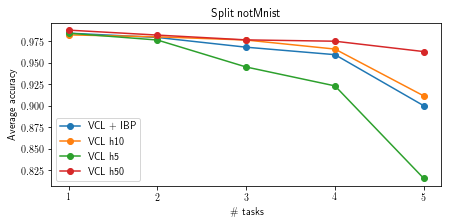

In [63]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result_h10 = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)
fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h10, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.set_title('Split notMnist')
ax.legend()
fig.show()

In [64]:
with open('results/not_mnist.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)

# Noisy MNIST

In [4]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = False
data_gen = SplitMnistRandomGenerator(val)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=learning_rate, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_not')

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.238910021
Epoch: 0006 cost= 0.007571174
Epoch: 0011 cost= 0.002408872
Epoch: 0016 cost= 0.001067212
Epoch: 0021 cost= 0.000563972
Epoch: 0026 cost= 0.000294330
Epoch: 0031 cost= 0.000188392
Epoch: 0036 cost= 0.000119834
Epoch: 0041 cost= 0.000083509
Epoch: 0046 cost= 0.000060130
Epoch: 0051 cost= 0.000042397
Epoch: 0056 cost= 0.000028523
Epoch: 0061 cost= 0.000021543
Epoch: 0066 cost= 0.000016567
Epoch: 0071 cost= 0.000011915
Epoch: 0076 cost= 0.000008848
Epoch: 0081 cost= 0.000006823
Epoch: 0086 cost= 0.000004895
Epoch: 0091 cost= 0.000003711
Epoch: 0096 cost= 0.000002855
Epoch: 0101 cost= 0.000002206
Epoch: 0106 cost= 0.000001648
Epoch: 0111 cost= 0.000001324
Epoch: 0116 cost= 0.000001002
Epoch: 0121 cost= 0.000000821
Epoch: 0126 cost= 0.000000573
Epoch: 0131 cost= 0.000000466
Epoch: 0136 cost= 0.000000356
Epoch: 0141 cost= 0.000000280
Epoch: 0146 cost= 0.000000210
Epoch: 0151 cost= 0.000000164
Epoch: 0156 cost= 0.000000130
Epoch: 0161 cost= 0.000000102
Epoch: 016

AttributeError: module 'tensorflow' has no attribute 'argsort'